File version: 1.1

In [54]:
import sys;

print('Python %s on %s' % (sys.version, sys.platform))
sys.path.extend(['../'])

Python 3.12.3 (tags/v3.12.3:f6650f9, Apr  9 2024, 14:05:25) [MSC v.1938 64 bit (AMD64)] on win32


In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scripts.data_utils import get_connectome

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA

from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

Functional Magnetic Resonance Imaging (fMRI) is a neuroimaging technique that enables the study of brain activity by detecting changes associated with blood flow. Unlike conventional MRI, which provides static images of brain structures, fMRI captures dynamic changes related to neural activity. This technique capitalizes on the Blood Oxygen Level-Dependent (BOLD) signal, which varies with the level of blood oxygenation. Active brain regions consume more oxygen, leading to alterations in the magnetic properties of hemoglobin depending on its oxygenation state. fMRI detects these variations, allowing researchers to identify specific brain areas activated in response to various stimuli or tasks. The data generated are three-dimensional images of the brain, where each voxel corresponds to a time series depicting changes in blood oxygen levels over time, effectively producing a four-dimensional dataset.

fMRI is utilized across diverse disciplines, including medicine, where it assists in neurosurgical planning and the diagnosis of neurological and psychiatric disorders such as epilepsy and schizophrenia. In psychophysiology, fMRI is employed to investigate brain function under normal and pathological conditions, as well as to study cognitive processes like memory, attention, and language.

A central objective in fMRI research is the classification of human brain states based on functional activity, as reflected in the BOLD signal. fMRI data are collected during resting states and during engagement in various tasks (e.g., solving cognitive problems), under both normal and pathological conditions, and across different levels of consciousness (e.g., wakefulness, sleep, anesthesia, coma). In clinical settings, accurately classifying pathological brain states is of paramount importance. Employing machine learning techniques to classify brain states presents a promising avenue for research. To effectively apply these methods to complex conditions—such as differentiating between healthy individuals and patients with schizophrenia, or among subtypes of schizophrenia—it is essential to validate their performance on simpler cases. A notable challenge with fMRI data is its high variability, originating from multiple sources, including differences in data acquisition protocols. Consequently, data acquired from different scanners and by different technicians may vary significantly, complicating model generalization across datasets.


## Task

One fundamental state of the human brain is the resting state with either eyes open or eyes closed. It is well-established that these states exhibit differences, particularly affecting the brain's visual cortex and associated structures. Experts can distinguish between these states through visual inspection of fMRI data. The objective of this research is to determine whether machine learning (ML) or deep learning (DL) approaches can accurately differentiate between these states. It is especially important to develop a model that can be trained on one dataset (e.g., publicly available data) and applied to proprietary data (e.g., clinical data from a specific institution).

This project proposes the development of an effective methodology for classifying resting states with eyes open and eyes closed using machine learning techniques. Two datasets are provided: data from various research projects at the Institute of the Human Brain of the Russian Academy of Sciences (IHB RAS) and an open dataset from Beijing Normal University. Both datasets consist of fMRI scans under two conditions—eyes closed and eyes open—and are presented as time-series data. 

Given the high dimensionality of raw fMRI data (e.g., 120 x 142 x 50 voxels in the IHB dataset), dimensionality reduction is commonly performed using brain atlases. These atlases partition the brain into regions corresponding to specific anatomical structures, allowing for the averaging of time series across all voxels within a region.


Here we suggest using the atlas [HCPex](https://github.com/waylan/HCPex), which has 426 regions, including 66 subcortical ones. (For our data there were some missing regions, so they were deleted. Resulting time-series has 419 regions)

Table with information about the atlas:

- **ID**: There are two ID columns in the table. The difference between them is sorting. `HCPex_ID` sorts the rows in the order specified in the HCPex atlas file: firstly, all regions of the left hemisphere (`Primary_Visual_Cortex_L` - L means left hemisphere), then the right. `SORTED_ID` sorts the rows in the order *left region-right region* (`Primary_Visual_Cortex_L`, `Primary_Visual_Cortex_R`,...)
- **Label**: the name of the region and the short form of the name
- **Cortical division**: which brain structure does the region belong to
- **X, Y, Z**: the coordinate of the centroid of the region
- **Functional network**: to which functional network regions belong. based on articles by the authors [Cole and Anticevic](https://github.com/ColeLab/ColeAnticevicNetPartition)

In [56]:
hcp_table = pd.read_excel('../data/atlas/HCPex_Atlas_Description.xlsx',
                          index_col='HCPex_ID').sort_index()
hcp_table.head()

,NEW_ID,Label,Short_label,Cortical Division,Cortical_Division_Number,X,Y,Z,ColeAnticevic_functional_network,ColeAnticevic_functional_network_label
HCPex_ID,,,,,,,,,,
1,1,Primary_Visual_Cortex_L,L_V1,Primary_Visual,1,-10.078,-84.159,1.759,1,Visual1
2,3,Second_Visual_Area_L,L_V2,Early_Visual,2,-12.044,-82.059,4.029,2,Visual2
3,5,Third_Visual_Area_L,L_V3,Early_Visual,2,-16.607,-84.793,7.259,2,Visual2
4,7,Fourth_Visual_Area_L,L_V4,Early_Visual,2,-29.556,-86.009,-1.542,2,Visual2
5,9,IntraParietal_Sulcus_Area_1_L,L_IPS1,Dorsal_Stream_Visual,3,-24.456,-74.776,38.047,2,Visual2


The predominant approach for training machine learning models on fMRI data involves the use of functional connectivity matrices. These matrices represent the similarity between the time-series data of different brain regions, typically calculated using pairwise Pearson correlation coefficients. The underlying assumption is that co-activated regions will exhibit similar temporal signals. 

Alternatively, raw time-series data can be utilized directly, or different similarity metrics can be employed to construct functional connectivity matrices.


(71, 240, 419)


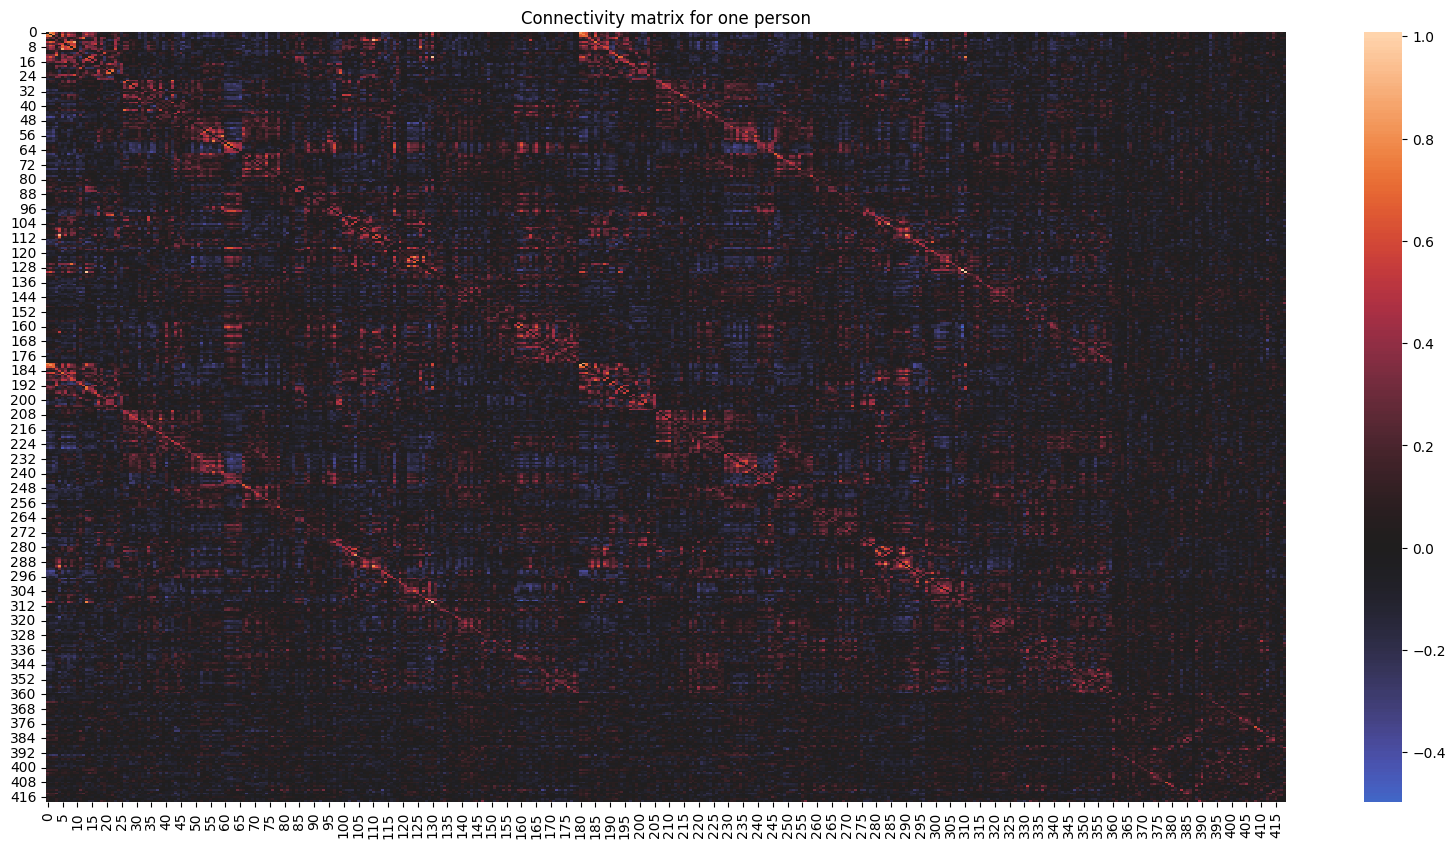

In [57]:
# load open data from Beijing Normal University
X = np.load('../data/ts_cut/HCPex/bnu1.npy')
print(X.shape)

# function to compute functional connectivity
cm = get_connectome(X)

plt.figure(figsize=(20, 10))
sns.heatmap(cm[0], center=0)
plt.title('Connectivity matrix for one person');

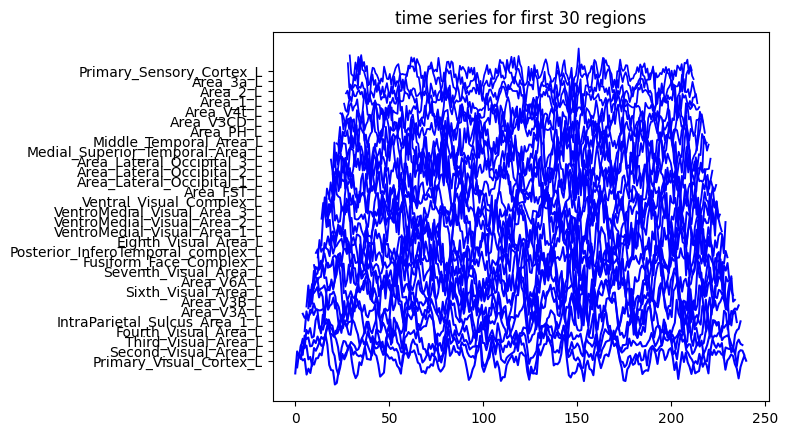

In [58]:
num_components_to_display = 30
tsd = X[0, :, :num_components_to_display]
for i in range(num_components_to_display):
    xscale = 1 - i / len(tsd) * 2
    lw = 1.5 - i / len(tsd) * 2
    plt.plot((xscale * np.linspace(-0.5, 0.5, len(tsd)) + 0.5) * len(tsd), i + tsd[:, i], color="b", lw=lw)
plt.gca().set_yticks(ticks=np.arange(num_components_to_display),
                     labels=hcp_table['Label'][:num_components_to_display].values)
plt.title(f'time series for first {num_components_to_display} regions')
plt.show()

## Data overview:

*Training data*

Beijing dataset:

- 47 participants with eyes open, 95 participants with eyes closed
- ``'../data/ts_cut/HCPex/bnu{1,2}.npy'`` and ``'../data/ts_cut/HCPex/bnu.csv'`` both with 142 records

IHB dataset:

- 10 participants with eyes open, 10 participants with eyes closed
- ``'../data/ts_cut/HCPex/ihb.npy'`` and ``'../data/ts_cut/HCPex/ihb.csv'`` both with 20 records

*Public Test Data:*

- IHB dataset: 20 participants with eyes open, 20 participants with eyes closed

*Private Test Data:*

IHB dataset: 
- 117 participants with eyes open, 117 participants with eyes closed

File with all $274$ records will accessible at Yandex Contest grading system by path ``'./data/ts_cut/HCPex/predict.npy'`` in the working directory. The file format is the same as training IHB dataset.


Note that test dataset contains data from different experiments. Therefore, the performance on private and public sets can be very different. Still the data shows the same thing - difference between opening and closing the eyes. 

## Objective
The task aims to simulate a realistic research workflow:

-	Data Collection Constraints: Collecting fMRI data is challenging and costly, resulting in small proprietary datasets.
-	Utilization of Public Datasets: Numerous publicly available datasets can be utilized for pre-training models.
-	Dataset Variability: These open datasets inherently differ from proprietary data in aspects such as scanner type, geographic location of data collection, and average age of participants.
The primary goal is to develop a model capable of generalizing across multiple datasets from diverse sources. While the difference between eyes open and eyes closed resting states is evident at the individual subject level, it is less pronounced in group analyses. Therefore, the model must be robust enough to detect these subtle differences across heterogeneous datasets.

## Performance Metric and Deliverables

*Evaluation Metric:* Accuracy score

*Required Deliverables:*
-	Model Weights: The trained model's weights for reproducibility and further analysis.
-	Executable Script: A script containing all necessary code to run the model, including data reading, preprocessing steps, model architecture, inference code.


## Example

In [59]:
# load both files with series

bnu_series_path = '../data/ts_cut/HCPex/bnu{}.npy'
bnu_labels_path = '../data/ts_cut/HCPex/bnu.csv'
ihb_series_path = '../data/ts_cut/HCPex/ihb.npy'
ihb_labels_path = '../data/ts_cut/HCPex/ihb.csv'

X_bnu = np.concatenate([np.load(bnu_series_path.format(i)) for i in (1, 2)], axis=0)
print(X_bnu.shape)
Y_bnu = pd.read_csv(bnu_labels_path)
print(Y_bnu.shape)
X_ihb = np.load(ihb_series_path)
print(X_ihb.shape)
Y_ihb = pd.read_csv(ihb_labels_path)
print(Y_ihb.shape)

# time series have different length
# by the way ``get_connectome`` reduces them to matrices 419x419

X_bnu = get_connectome(X_bnu)
X_ihb = get_connectome(X_ihb)

# concat the train data
X = np.concatenate([X_bnu, X_ihb])
Y = np.concatenate([Y_bnu, Y_ihb])

X.shape, Y.shape

(142, 240, 419)
(142, 1)
(20, 120, 419)
(20, 1)


((162, 419, 419), (162, 1))

Here is a logistic regression, which takes functional connectivity matrices in form of vectors, which are transformed using PCA

In [60]:
from sklearn.decomposition import PCA


n_samples = X.shape[0]
X_reshaped = X.reshape(n_samples, -1)
pca = PCA(n_components=0.9)
X_pca = pca.fit_transform(X_reshaped)
print(f"X shape: {X_reshaped.shape}")
print(f"X pca shape: {X_pca.shape}")

X shape: (162, 175561)
X pca shape: (162, 118)


In [61]:

# from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
# model = RandomForestClassifier(random_state=42)


# model = RandomForestClassifier()
# param_grid = {
#     'n_estimators': [50, 75, 100, 150, 200, 250],
#     'max_depth': [None, 2, 3, 5, 7, 10, 15, 20, 30],
#     'class_weight': ['balanced', None]
# }

# grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
# grid_search.fit(X_pca, Y.ravel())

# print(f"Best parameters: {grid_search.best_params_}")
# print(f"Best cross-validated F1 score: {grid_search.best_score_:.4f}")

In [62]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


model = RandomForestClassifier(class_weight='balanced', max_depth=2, n_estimators=250)


model.fit(X_pca, Y.ravel())
y_pred = model.predict(X_pca)

accuracy = accuracy_score(Y, y_pred)
print(f'Accuracy: {accuracy:.2f}')


Accuracy: 0.98


In [63]:
import pickle


with open('model.pkl', 'wb') as file:
    pickle.dump({'pca': pca, 'model': model}, file)

In [64]:
# create local environment same as Yandex Contest
import os
import shutil

if not os.path.exists('./data/ts_cut/HCPex/'):
    os.makedirs('./data/ts_cut/HCPex/')

np.save('./data/ts_cut/HCPex/predict.npy', np.concatenate([np.load(bnu_series_path.format(i)) for i in (1, 2)], axis=0))


In [65]:
import numpy as np
import pandas as pd
import pickle

from scripts.data_utils import get_connectome

X = np.load('./data/ts_cut/HCPex/predict.npy')
print(X.shape)
X = get_connectome(X)

with open('model.pkl', 'rb') as file:
    saved_objects = pickle.load(file)

pca = saved_objects['pca']
model = saved_objects['model']

# Применяем сохранённый PCA для трансформации данных
n_samples = X.shape[0]
X_reshaped = X.reshape(n_samples, -1)
X_pca = pca.transform(X_reshaped)

# Предсказываем
y_pred = model.predict(X_pca)

# Сохраняем предсказания в CSV
solution = pd.DataFrame(data=y_pred, columns=['prediction'])
solution.to_csv('./solution.csv', index=False)

(142, 240, 419)


In [66]:
# build the .zip to submit
import zipfile
import datetime

# save source from previous cell into file
# will produce the correct result only in case of running previous cell just before
with open('run.py', 'w') as f_run:
    f_run.write(_ih[-2])

with open('run.sh', 'w') as f_run_sh:
    f_run_sh.write('export PATH=/usr/conda/bin:$PATH\npython run.py')

with open('train.py', 'w') as f_run:
    f_run.write('print("\\n".join(map(str, range(100))))')

with open('train.sh', 'w') as f_run_sh:
    f_run_sh.write('export PATH=/usr/conda/bin:$PATH\npython train.py')

with open('Makefile', 'w') as f_makefile:
    f_makefile.write('''all: build

build:
	@echo 'starting....'
	bash train.sh
run:
	bash run.sh
train:
	bash train.sh
''')

submission_zip = zipfile.ZipFile(f"submission-{datetime.datetime.now()}.zip".replace(':', '-').replace(' ', '-'), "w")
submission_zip.write('./Makefile', compress_type=zipfile.ZIP_DEFLATED)
submission_zip.write('run.py', compress_type=zipfile.ZIP_DEFLATED)
submission_zip.write('run.sh', compress_type=zipfile.ZIP_DEFLATED)
submission_zip.write('train.py', compress_type=zipfile.ZIP_DEFLATED)
submission_zip.write('train.sh', compress_type=zipfile.ZIP_DEFLATED)
submission_zip.write('model.pkl', compress_type=zipfile.ZIP_DEFLATED)
submission_zip.write('scripts', compress_type=zipfile.ZIP_DEFLATED)
submission_zip.write('scripts/__init__.py', compress_type=zipfile.ZIP_DEFLATED)
submission_zip.write('scripts/classification_models.py', compress_type=zipfile.ZIP_DEFLATED)
submission_zip.write('scripts/data_utils.py', compress_type=zipfile.ZIP_DEFLATED)

submission_zip.close()
